In [1]:
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from langchain_core.messages import HumanMessage, SystemMessage
from pprint import pprint
from langfuse.callback import CallbackHandler

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0.2)
langfuse_handler = CallbackHandler()

In [2]:
class Route(BaseModel):
    step: Literal["joke", "story", "poem"] = Field(
        None, description="The next step in the routing process"
    )

router = llm.with_structured_output(Route)

class State(TypedDict):
    input: str
    decision: str
    output: str

def create_joke(state:State):
    result = llm.invoke(state["input"])
    return {"output": result.content}

def create_story(state:State):
    result = llm.invoke(state["input"])
    return {"output": result.content}

def create_poem(state:State):
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_router(state: State):
    decision = router.invoke(
        [
            SystemMessage(content = "Route the input to story, joke or poem based on the user's request"),
            HumanMessage(content = state["input"]),
        ]
    )

    return {"decision": decision.step}

def route_decision(state: State):
    if state["decision"] == "joke":
        return "create_joke"# create_joke(state)
    elif state["decision"] == "story":
        return "create_story" #create_story(state)
    elif state["decision"] == "poem":
        return "create_poem" #create_poem(state)
    else:
        raise ValueError(f"Invalid decision: {state['decision']}")

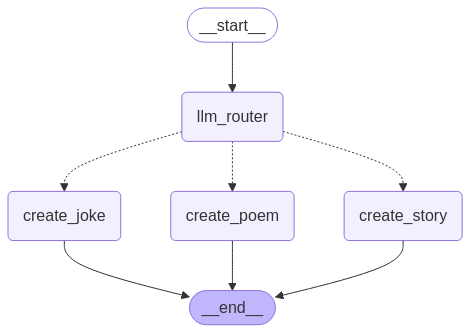

In [5]:
router_builder = StateGraph(State)

router_builder.add_node("llm_router", llm_router)
router_builder.add_edge(START, "llm_router")

router_builder.add_node("create_story", create_story)
router_builder.add_node("create_poem", create_poem)
router_builder.add_node("create_joke", create_joke)

router_builder.add_conditional_edges("llm_router", route_decision, 
                                     {"create_joke": "create_joke", "create_story": "create_story", "create_poem": "create_poem"}
)

router_builder.add_edge("create_story", END)
router_builder.add_edge("create_joke", END)
router_builder.add_edge("create_poem", END)
router_graph = router_builder.compile()

display(Image(router_graph.get_graph().draw_mermaid_png()))

In [6]:
state = router_graph.invoke({"input": "write me a joke about AirBnb"}, config={"callbacks": [langfuse_handler]})
pprint(state)

{'decision': 'joke',
 'input': 'write me a joke about AirBnb',
 'output': 'Why did the scarecrow get an Airbnb?\n'
           '\n'
           'Because he wanted to be outstanding in his field!'}


In [7]:
state = router_graph.invoke({"input": "write me a short poem about AirBnb"}, config={"callbacks": [langfuse_handler]})

In [8]:
pprint(state)

{'decision': 'poem',
 'input': 'write me a short poem about AirBnb',
 'output': 'In cozy nooks where travelers roam,  \n'
           "A stranger's space becomes a home.  \n"
           'With whispered tales in every room,  \n'
           'And laughter shared, dispelling gloom.  \n'
           '\n'
           'From city lights to mountain views,  \n'
           'Each listing holds a world to choose.  \n'
           'A kitchen warm, a garden bright,  \n'
           'Airbnb, where dreams take flight.  \n'
           '\n'
           'So pack your bags, let wanderlust steer,  \n'
           'In every stay, new memories near.  \n'
           'With open doors and hearts so free,  \n'
           'The world feels small, through Airbnb.  '}
